In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

In [ ]:
data = {"City": ["Delhi", "delhi", "Mumbai", "Mum bai", "Kolkata", "KOLKATA", "Delhi   ", "Chennai", "Chennai", "Bengaluru", "bglr", "Bangalore", "Delhi", "Unknown", "NA"] }

In [ ]:
df=pd.DataFrame(data)
df

,City
0,Delhi
1,delhi
2,Mumbai
3,Mum bai
4,Kolkata
5,KOLKATA
6,Delhi
7,Chennai
8,Chennai
9,Bengaluru


In [ ]:
df['cleaned_cities']=df['City'].str.strip().str.lower()

In [ ]:
city_mapping={"delhi": "delhi",
              "mumbai": "mumbai",
              "mum bai": "mumbai",
              "kolkata": "kolkata",
              "chennai": "chennai",
              "bengaluru": "bengaluru",
              "bangalore": "bengaluru",
              "bglr": "bengaluru"}

In [ ]:
df['standardized_cities']=df['cleaned_cities'].map(city_mapping)

In [ ]:
df

,City,cleaned_cities,standardized_cities
0,Delhi,delhi,delhi
1,delhi,delhi,delhi
2,Mumbai,mumbai,mumbai
3,Mum bai,mum bai,mumbai
4,Kolkata,kolkata,kolkata
5,KOLKATA,kolkata,kolkata
6,Delhi,delhi,delhi
7,Chennai,chennai,chennai
8,Chennai,chennai,chennai
9,Bengaluru,bengaluru,bengaluru


In [ ]:
df_cleaned=df[~df['standardized_cities'].isna()]

Count Plot before Resampling

Text(0, 0.5, 'Count')

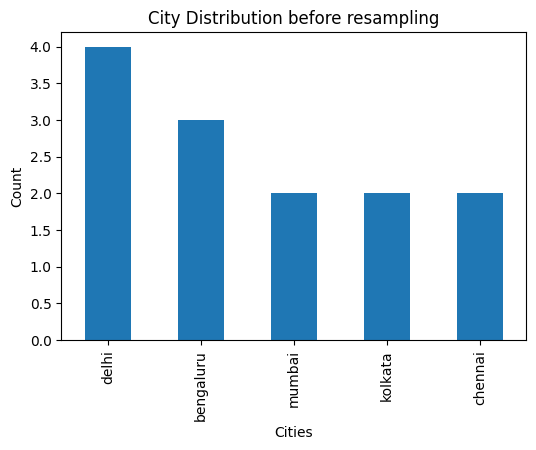

In [ ]:
plt.figure(figsize=(6,4))
df_cleaned['standardized_cities'].value_counts().plot(kind='bar')
plt.title('City Distribution before resampling')
plt.xlabel('Cities')
plt.ylabel('Count')

In [ ]:
major_cities=df_cleaned[df_cleaned['standardized_cities']=='delhi']
minor_cities=df_cleaned[df_cleaned['standardized_cities']!='delhi']

In [ ]:
#upsampling
minor_resampled=resample(minor_cities, replace=True,n_samples=len(major_cities), random_state=34)
df_resampled=pd.concat([major_cities, minor_resampled])

In [ ]:
df_resampled

,City,cleaned_cities,standardized_cities
0,Delhi,delhi,delhi
1,delhi,delhi,delhi
6,Delhi,delhi,delhi
12,Delhi,delhi,delhi
3,Mum bai,mum bai,mumbai
9,Bengaluru,bengaluru,bengaluru
8,Chennai,chennai,chennai
7,Chennai,chennai,chennai


<Axes: xlabel='standardized_cities'>

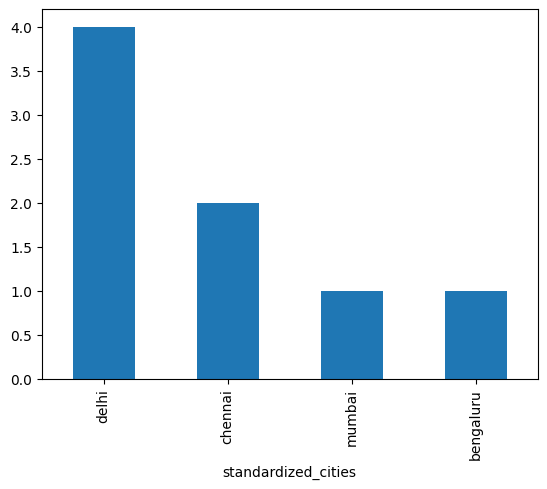

In [ ]:
df_resampled['standardized_cities'].value_counts().plot(kind='bar')

Why did your after-resampling chart look wrong?

Because the example code did a bad resampling strategy:

major_city = df_cleaned[df_cleaned['City_standardized'] == "delhi"]
minor_city = df_cleaned[df_cleaned['City_standardized'] != "delhi"]
minor_resampled = resample(minor_city, replace=True, n_samples=len(major_city))


This combined all minority categories into one group, then resampled them together.
While resampling, some categories got less representation by random chance.

👉 That’s why Mumbai disappeared — it got randomly underrepresented inside the mixed group.

This is NOT how proper categorical resampling should be done.

Correct Method:

Oversample each minority category separately
so that every category reaches same count as the majority

In [ ]:
before_counts=df_cleaned['standardized_cities'].value_counts()

In [ ]:
min_count=before_counts.min

In [ ]:
print("=== DEBUG CHECK START ===")
print("City values in before_counts:", before_counts.index.tolist())
print("Unique values in df_cleaned:", df_cleaned['standardized_cities'].unique().tolist())

print("\nRow counts per city BEFORE loop:")
for city in before_counts.index:
    count_rows = df_cleaned[df_cleaned['standardized_cities'] == city].shape[0]
    print(f"{city}: {count_rows}")

print("=== DEBUG CHECK END ===\n")


=== DEBUG CHECK START ===
City values in before_counts: ['delhi', 'bengaluru', 'mumbai', 'kolkata', 'chennai']
Unique values in df_cleaned: ['delhi', 'mumbai', 'kolkata', 'chennai', 'bengaluru']

Row counts per city BEFORE loop:
delhi: 4
bengaluru: 3
mumbai: 2
kolkata: 2
chennai: 2
=== DEBUG CHECK END ===



In [ ]:
second_highest = sorted(before_counts.values)[-2]
print("second_highest =", second_highest)

second_highest = 3


In [ ]:
resampled_frames=[]
for city,counts in before_counts.items():
  city_df=df_cleaned[df_cleaned['standardized_cities']==city]
  if counts==min_count:
    city_df=resample(city_df, random_state=34, n_samples=min_count+1, replace=True)
    resampled_frames.append(city_df)


In [ ]:
print("before_counts keys:", before_counts.index.tolist())
print("unique in df_cleaned:", df_cleaned['standardized_cities'].unique().tolist())

before_counts keys: ['delhi', 'bengaluru', 'mumbai', 'kolkata', 'chennai']
unique in df_cleaned: ['delhi', 'mumbai', 'kolkata', 'chennai', 'bengaluru']


In [ ]:
resampled_frames = []

for city, count in before_counts.items():
    city_df = df_cleaned[df_cleaned['standardized_cities'] == city]

    print(f"\nLooping: {city} | Rows Found: {len(city_df)}")

    if count < second_highest:
        print(f"Resampling: {city} from {count} -> {second_highest}")
        city_df = resample(city_df, replace=True, n_samples=second_highest, random_state=42)

    print(f"Appending: {city_df.shape}")
    resampled_frames.append(city_df)

print("\nTotal frames to concat:", len(resampled_frames))


Looping: delhi | Rows Found: 4
Appending: (4, 3)

Looping: bengaluru | Rows Found: 3
Appending: (3, 3)

Looping: mumbai | Rows Found: 2
Resampling: mumbai from 2 -> 3
Appending: (3, 3)

Looping: kolkata | Rows Found: 2
Resampling: kolkata from 2 -> 3
Appending: (3, 3)

Looping: chennai | Rows Found: 2
Resampling: chennai from 2 -> 3
Appending: (3, 3)

Total frames to concat: 5


In [ ]:
df_resampled=pd.concat(resampled_frames)

In [ ]:
after_counts=df_resampled['standardized_cities'].value_counts()

In [ ]:
df_resampled

,City,cleaned_cities,standardized_cities
0,Delhi,delhi,delhi
1,delhi,delhi,delhi
6,Delhi,delhi,delhi
12,Delhi,delhi,delhi
9,Bengaluru,bengaluru,bengaluru
10,bglr,bglr,bengaluru
11,Bangalore,bangalore,bengaluru
2,Mumbai,mumbai,mumbai
3,Mum bai,mum bai,mumbai
2,Mumbai,mumbai,mumbai
